In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
# Load data
df = pd.read_csv("/Users/myspecialonebrigitta/Desktop/steel_industry.csv")

# Convert 'Time' to datetime(a python norm)
df['Time'] = pd.to_datetime(df['Time'])

# Create 'date' and 'hour' columns
df['date'] = df['Time'].dt.date
df['hour'] = df['Time'].dt.floor('h').dt.time  # round down to hour, extract just time (e.g., 01:00:00)

# Pivot the data: each row is one day, each column is one hour
pivot_df = df.pivot(index='date', columns='hour', values='Load')

# Save the clean hourly load matrix
pivot_df.to_csv("daily_load_matrix.csv")


In [3]:
pivot_df = pivot_df.dropna() 
pivot_df.shape     
pivot_df.head()

hour,00:00:00,01:00:00,02:00:00,03:00:00,04:00:00,05:00:00,06:00:00,07:00:00,08:00:00,09:00:00,...,14:00:00,15:00:00,16:00:00,17:00:00,18:00:00,19:00:00,20:00:00,21:00:00,22:00:00,23:00:00
date,,,,,,,,,,,,,,,,,,,,,
2018-01-01,13.72,14.30,13.76,14.47,13.89,14.18,13.79,13.64,14.44,15.19,...,15.16,15.58,15.49,14.86,15.16,14.90,15.54,14.87,14.00,13.86
2018-01-02,13.68,14.41,13.83,14.40,13.76,14.04,13.86,22.61,183.47,209.04,...,478.19,474.18,456.56,372.89,154.47,154.90,79.24,22.21,18.93,18.29
2018-01-03,18.36,18.46,18.46,18.53,18.33,18.25,18.36,28.08,326.16,364.79,...,260.24,270.87,425.20,454.10,156.10,158.18,120.85,23.69,19.00,18.47
2018-01-04,18.50,18.54,18.54,18.58,18.50,18.47,18.46,24.77,458.89,508.39,...,476.39,474.41,450.18,361.09,204.88,227.13,216.72,24.77,19.40,18.53
2018-01-05,18.80,18.58,18.60,18.62,18.44,18.53,18.47,23.90,424.94,462.39,...,373.58,465.98,419.04,379.97,236.77,231.67,156.88,23.01,16.59,16.38


In [4]:
# Drop any non-numeric columns, like 'cluster' or 'label'
X = pivot_df.select_dtypes(include='number')  # only keeps numeric columns

# Standardize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [5]:
kmeans = KMeans(n_clusters=3, random_state=42)
pivot_df['cluster'] = kmeans.fit_predict(X_scaled)

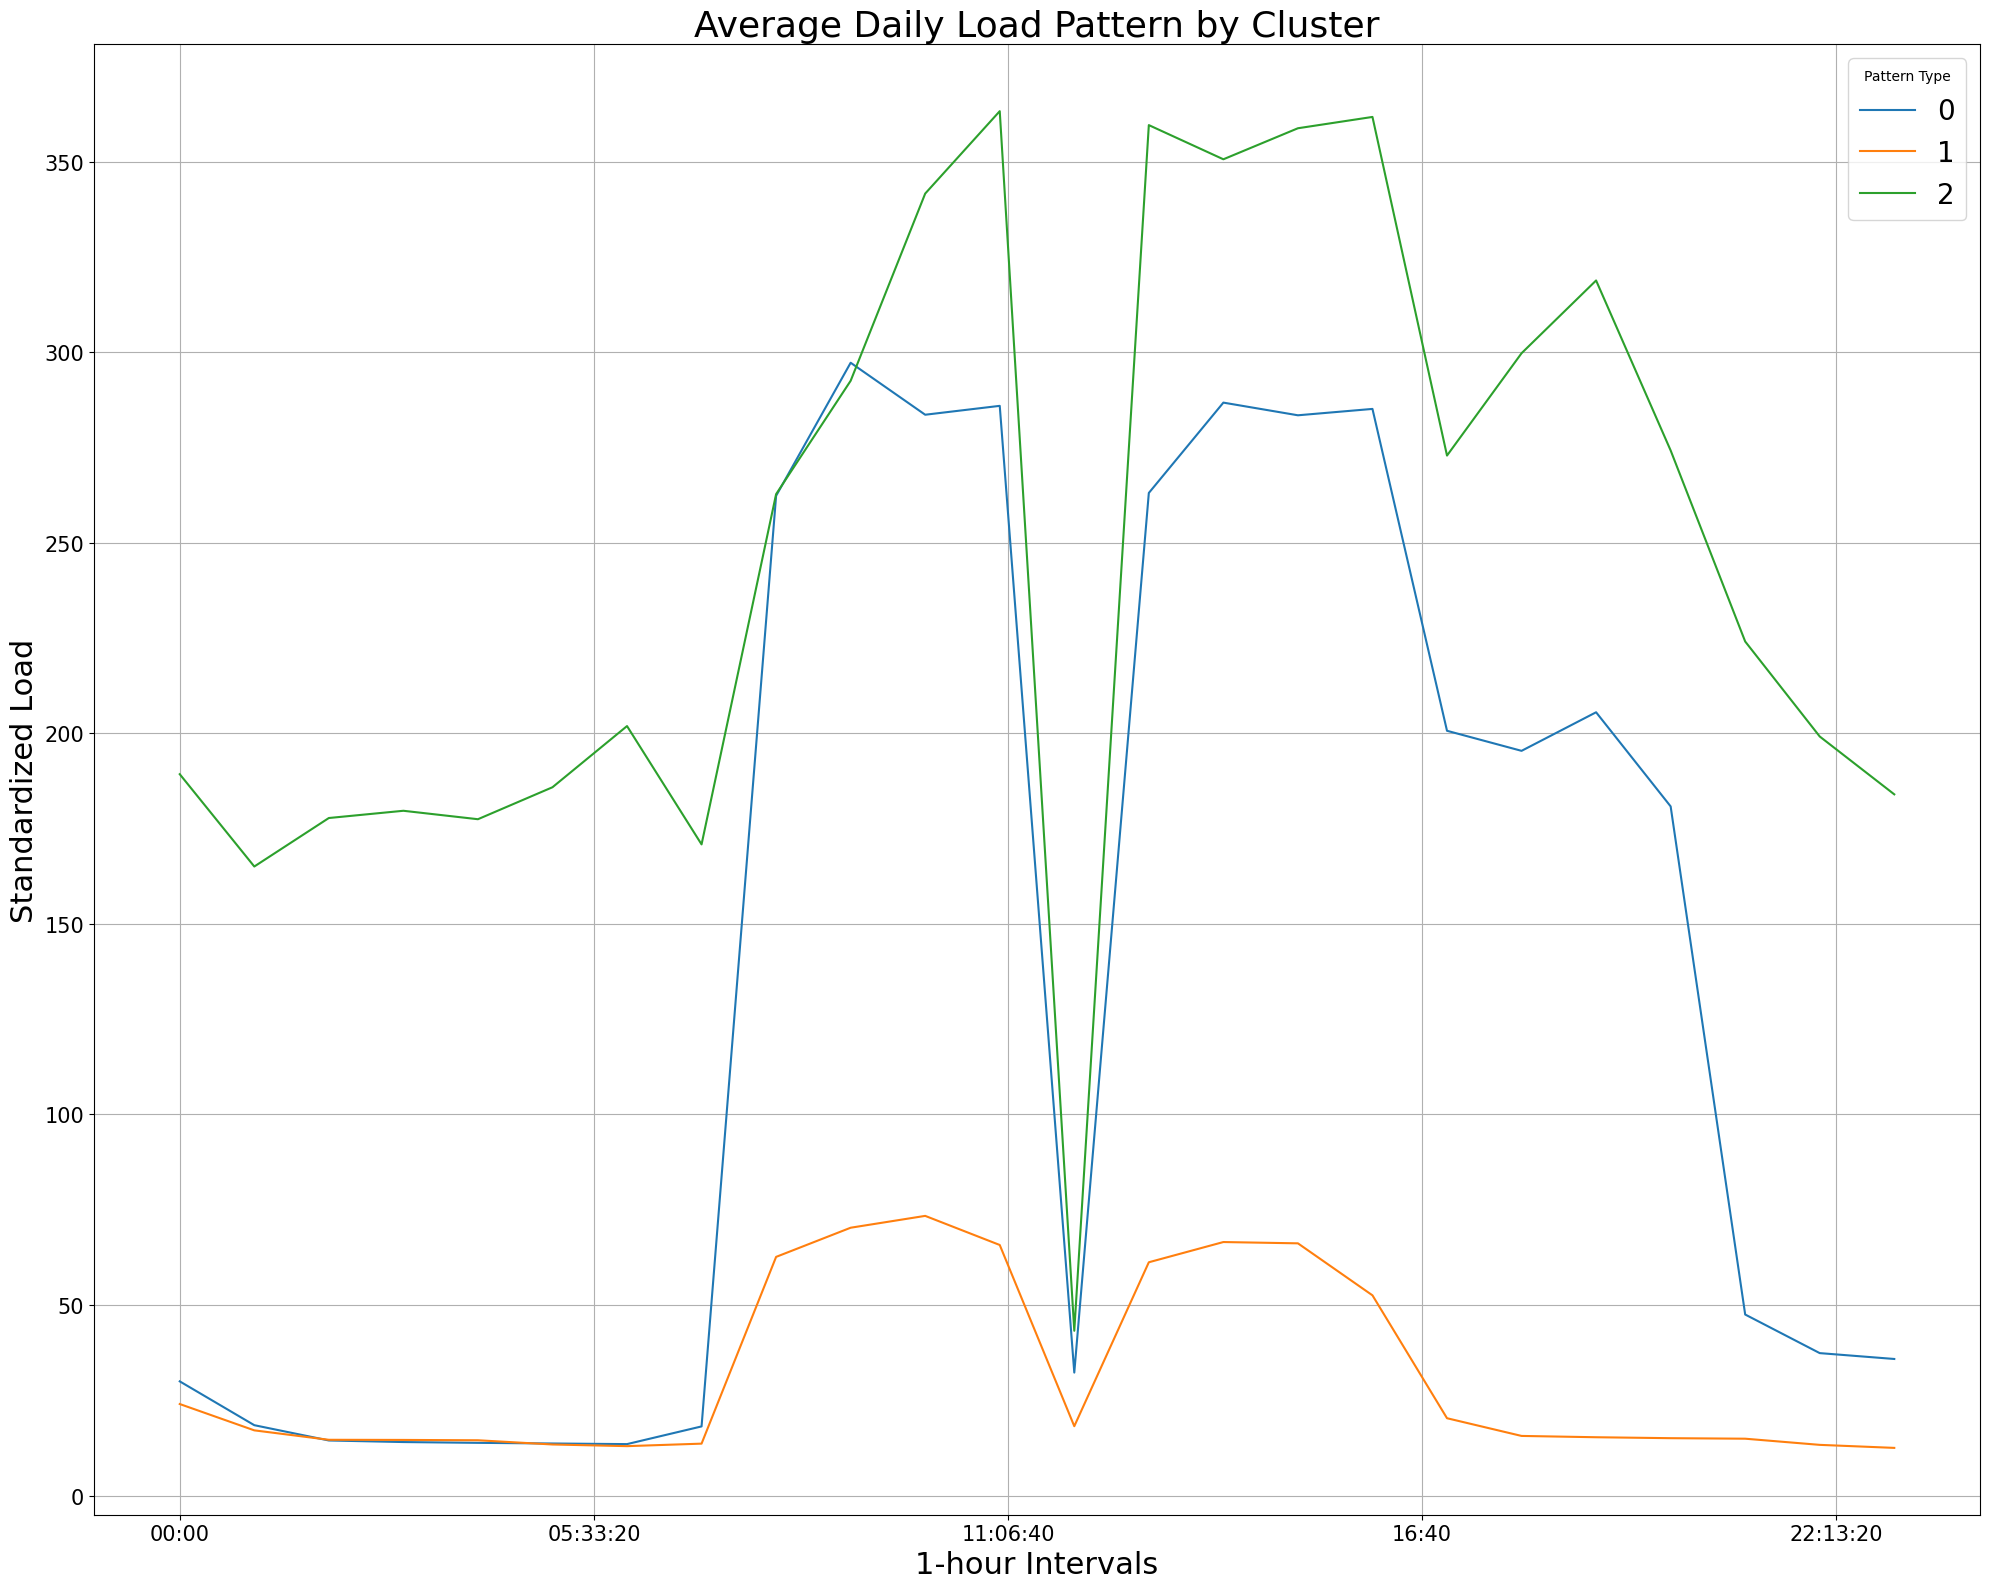

In [6]:
load_columns = pivot_df.columns[:24]

assert 'cluster' in pivot_df.columns, "Missing 'cluster' column. Run KMeans first."
avg_by_label = pivot_df.groupby("cluster")[load_columns].mean()
# Define custom labels
cluster_name_map = {
    0: "low_base_high_peak",
    1: "low_base_low_peak",
    2: "high_load_high_peak"
}

# Rename cluster index to meaningful names
avg_by_label.index = avg_by_label.index.map(cluster_name_map)
avg_by_label = pivot_df.groupby("cluster")[pivot_df.columns[:24]].mean()
#transposes the table so that X-axis=time of day, Y-axis=average load
avg_by_label.T.plot(figsize=(20, 16))
plt.title("Average Daily Load Pattern by Cluster", fontsize=26)
plt.xlabel("1-hour Intervals",fontsize=22)
plt.ylabel("Standardized Load",fontsize=22)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(title="Pattern Type",fontsize=20)
plt.grid(True)
plt.tight_layout()
plt.show()

In [8]:
pivot_df.to_csv("daily_load_with_clusters_and_labels.csv")

In [9]:
# Define hourly columns again if needed
hourly_cols = pivot_df.columns[:24]

# New features
pivot_df['total_load'] = pivot_df[hourly_cols].sum(axis=1)
pivot_df['peak_load'] = pivot_df[hourly_cols].max(axis=1)
pivot_df['valley_load'] = pivot_df[hourly_cols].min(axis=1)
pivot_df['avg_load'] = pivot_df[hourly_cols].mean(axis=1)
pivot_df['load_range'] = pivot_df['peak_load'] - pivot_df['valley_load']
pivot_df['load_std'] = pivot_df[hourly_cols].std(axis=1)

# Time of peak and valley (converted to hour index 0–23)
pivot_df['peak_hour'] = pivot_df[hourly_cols].idxmax(axis=1).astype(str).str[:2].astype(int)
pivot_df['valley_hour'] = pivot_df[hourly_cols].idxmin(axis=1).astype(str).str[:2].astype(int)


In [10]:
pivot_df['date'] = pd.to_datetime(pivot_df.index)

pivot_df['day_of_week'] = pivot_df['date'].dt.dayofweek  # 0=Monday
pivot_df['is_weekend'] = pivot_df['day_of_week'].isin([5,6]).astype(int)
pivot_df['month'] = pivot_df['date'].dt.month

def get_season(month):
    if month in [3,4,5]:
        return 'Spring'
    elif month in [6,7,8]:
        return 'Summer'
    elif month in [9,10,11]:
        return 'Fall'
    else:
        return 'Winter'

pivot_df['season'] = pivot_df['month'].apply(get_season)


In [11]:
# Ratio of peak to mean
pivot_df['peak_to_mean'] = pivot_df['peak_load'] / (pivot_df['avg_load'] + 1e-6)

# Ratio of peak to total
pivot_df['peak_to_total'] = pivot_df['peak_load'] / (pivot_df['total_load'] + 1e-6)


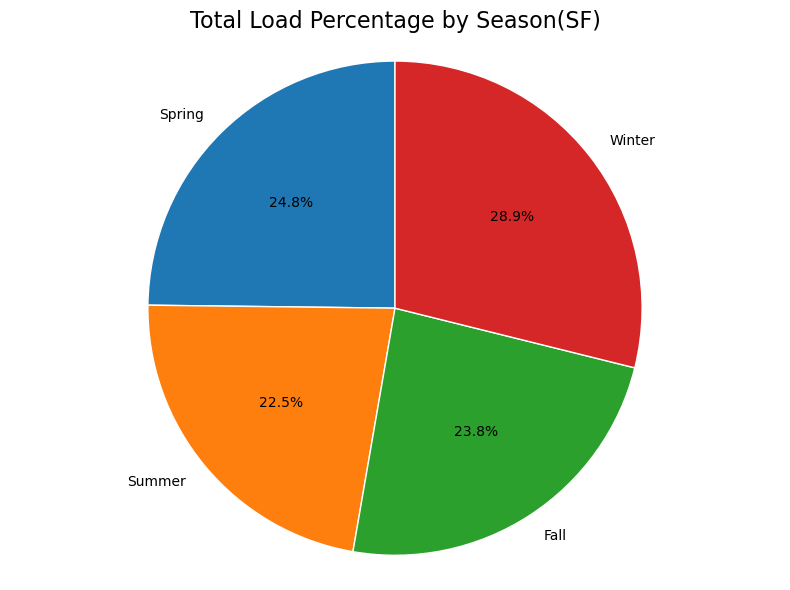

In [13]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. Make sure 'season' column exists
# If not already present:
pivot_df['date'] = pd.to_datetime(pivot_df.index)
pivot_df['month'] = pivot_df['date'].dt.month

def get_season(month):
    if month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    elif month in [9, 10, 11]:
        return 'Fall'
    else:
        return 'Winter'

pivot_df['season'] = pivot_df['month'].apply(get_season)

# 2. Identify hourly columns
hourly_cols = [col for col in pivot_df.columns if isinstance(col, str) and col.endswith(':00:00')]

# Sanity check: if hourly_cols are empty, fallback to first 24 columns
if not hourly_cols:
    hourly_cols = pivot_df.columns[:24]

# 3. Compute total load per day
pivot_df['total_load'] = pivot_df[hourly_cols].sum(axis=1)

# 4. Group by season and compute total load
season_total = pivot_df.groupby('season')['total_load'].sum()

# Optional: reorder the index to a logical seasonal sequence
season_order = ['Spring', 'Summer', 'Fall', 'Winter']
season_total = season_total.reindex(season_order).dropna()

# 5. Plot pie chart
plt.figure(figsize=(8, 6))
plt.pie(
    season_total,
    labels=season_total.index,
    autopct='%1.1f%%',
    startangle=90,
    wedgeprops={'edgecolor': 'white'}
)
plt.title("Total Load Percentage by Season(SF)", fontsize=16)
plt.axis('equal')
plt.tight_layout()
plt.show()


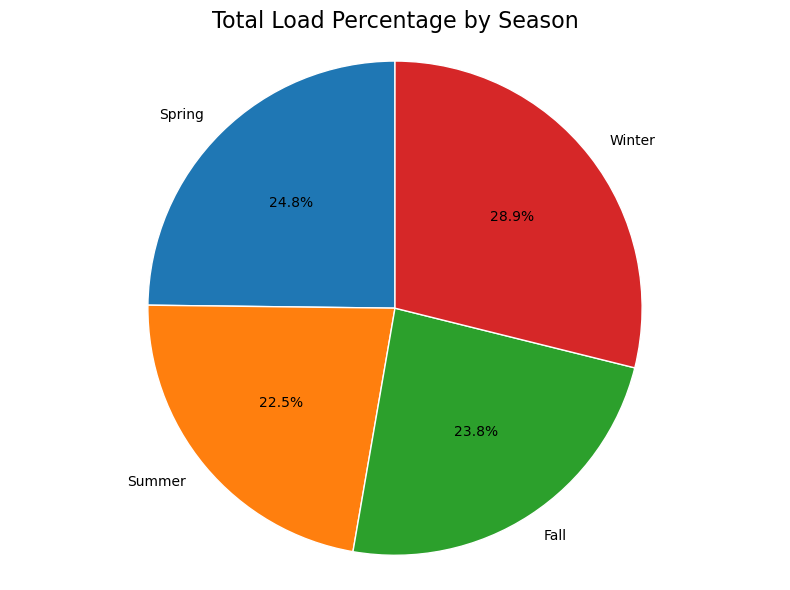

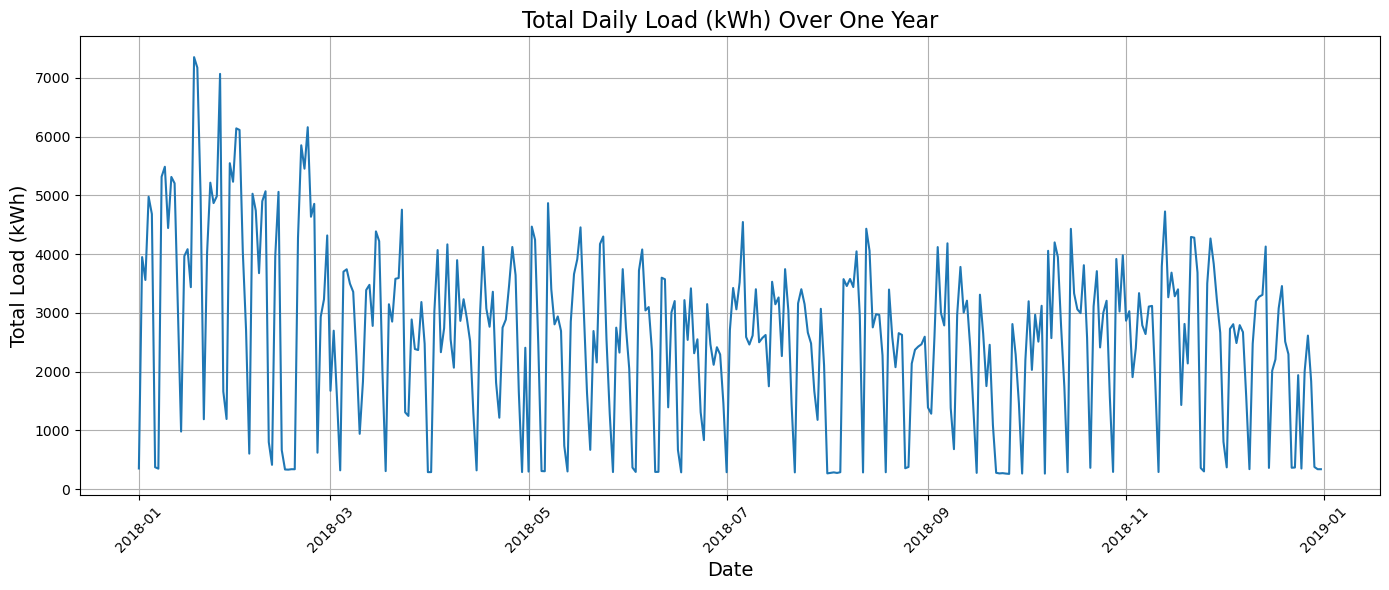

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

# 1. Load & prepare data
df = pd.read_csv("/Users/myspecialonebrigitta/Desktop/steel_industry.csv")
df['Time'] = pd.to_datetime(df['Time'])
df['date'] = df['Time'].dt.date
df['hour'] = df['Time'].dt.floor('h').dt.time

# 2. Pivot: rows = dates, columns = hours
pivot_df = df.pivot(index='date', columns='hour', values='Load')

# 3. Reset index and convert 'date' back to datetime
pivot_df.reset_index(inplace=True)
pivot_df['date'] = pd.to_datetime(pivot_df['date'])

# 4. Identify hourly load columns (first 24 columns after 'date')
hourly_cols = [col for col in pivot_df.columns if isinstance(col, str) and col.endswith(':00:00')]
if not hourly_cols:
    hourly_cols = pivot_df.columns[1:25]  # skip 'date', assume first 24 time cols

# 5. Total daily load (kWh)
pivot_df['total_load_kwh'] = pivot_df[hourly_cols].sum(axis=1)

# 6. Add month and season columns
pivot_df['month'] = pivot_df['date'].dt.month

def get_season(month):
    if month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    elif month in [9, 10, 11]:
        return 'Fall'
    else:
        return 'Winter'

pivot_df['season'] = pivot_df['month'].apply(get_season)

# -------------------------
# 🎯 Plot 1: Pie chart of total load by season
# -------------------------
season_total = pivot_df.groupby('season')['total_load_kwh'].sum()
season_order = ['Spring', 'Summer', 'Fall', 'Winter']
season_total = season_total.reindex(season_order).dropna()

plt.figure(figsize=(8, 6))
plt.pie(season_total, labels=season_total.index, autopct='%1.1f%%', startangle=90, wedgeprops={'edgecolor': 'white'})
plt.title("Total Load Percentage by Season", fontsize=16)
plt.axis('equal')
plt.tight_layout()
plt.show()

# -------------------------
# 🎯 Plot 2: Line chart of total daily load over the year
# -------------------------
pivot_df = pivot_df.sort_values('date')

plt.figure(figsize=(14, 6))
plt.plot(pivot_df['date'], pivot_df['total_load_kwh'], linewidth=1.5)
plt.title("Total Daily Load (kWh) Over One Year", fontsize=16)
plt.xlabel("Date", fontsize=14)
plt.ylabel("Total Load (kWh)", fontsize=14)
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
$